In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Flatten
from keras.engine import  Model
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

import os

Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("../input/recognizing-faces-in-the-wild/train_relationships.csv")
sample = pd.read_csv("../input/recognizing-faces-in-the-wild/sample_submission.csv")

In [3]:
train_df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [4]:
train_df.iloc[0].p1

'F0002/MID1'

In [5]:
sample.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [6]:
import zipfile
# Will unzip the files so that you can see them..
with zipfile.ZipFile("/kaggle/input/recognizing-faces-in-the-wild/train.zip","r") as z:
    z.extractall("/kaggle/train")

In [7]:
!pip install keras_vggface
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace

In [8]:


def read_img(img_dir, preprocess=False):
    img = load_img(img_dir, target_size=(224,224))
    if preprocess:
        img = np.array(img).astype(np.float)
        img = preprocess_input(img)
    return img

def read_pair_img(p1, p2, image_dir):

    dir1,dir2 = os.listdir(image_dir+'/'+p1), os.listdir(image_dir+'/'+p2)
    
    
    n1, n2 = min(5, len(dir1)), min(5, len(dir2))
    
    fig1, ax1 = plt.subplots(1, n1, figsize=(10, 10))
    fig2, ax2 = plt.subplots(1, n2, figsize=(10, 10))

    for i in range(n1):
    
        img1= read_img(image_dir+'/'+p1+'/'+dir1[i])
        ax1[i].imshow(img1)
        ax1[i].set_title('Related 1: '+dir1[i], fontsize='small')

    for i in range(n2):
        img2= Image.open(image_dir+'/'+p2+'/'+dir2[i])
        ax2[i].imshow(img2)
        ax2[i].set_title('Related 2: '+dir2[i], fontsize='small')
        
    fig1.tight_layout()
    fig2.tight_layout()
    plt.show()

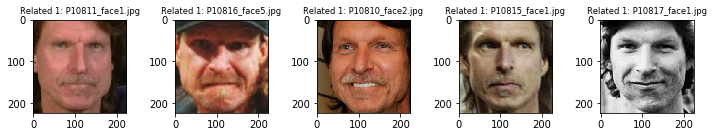

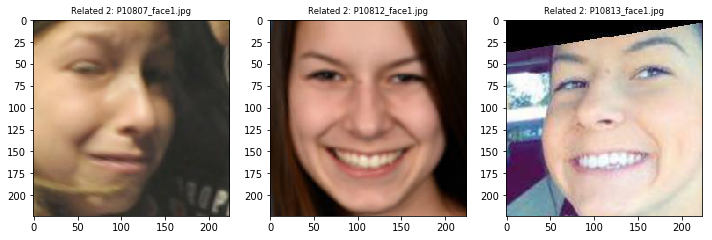

In [9]:
pair = train_df.iloc[130]

read_pair_img(pair.p1 ,pair.p2 , '/kaggle/train')

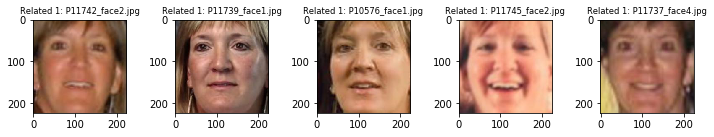

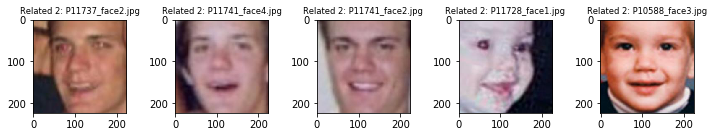

In [10]:
pair = train_df.iloc[19]

read_pair_img(pair.p1 ,pair.p2 , '/kaggle/train')

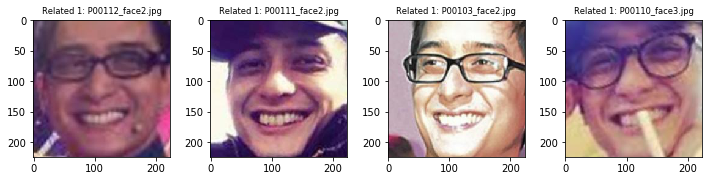

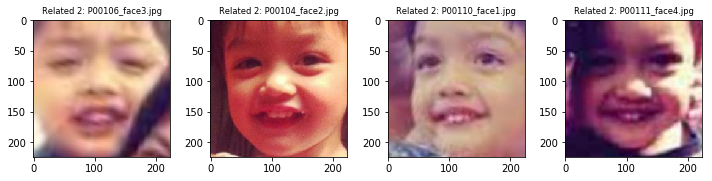

In [11]:
pair = train_df.iloc[24]

read_pair_img(pair.p1 ,pair.p2 , '/kaggle/train')

In [12]:
all_members = set()
map_relate = {}
img_df = []
train_dir = '/kaggle/train/'
for index,row in train_df.iterrows():
    all_members.update([row.p1, row.p2])
    
    if row.p1 not in map_relate:
        map_relate[row.p1] = set([row.p2])
    else:
        map_relate[row.p1].add(row.p2)
    
    if row.p2 not in map_relate:
        map_relate[row.p2] = set([row.p1])
    else:
        map_relate[row.p2].add(row.p1)
    try:
        
        img1, img2 = os.listdir(train_dir+row.p1), os.listdir(train_dir+row.p2)
    except:
        continue
    if(len(img1)*len(img2) == 0): continue
    for l in img1:
        for r in img2:
            img_df.append([train_dir+row.p1 + '/'+l,train_dir+row.p2 + '/'+r,1])


In [13]:
img_df = pd.DataFrame(img_df, columns=['p1','p2','labels'])

In [14]:
len(img_df)

165179

In [15]:
img_df.head()

,p1,p2,labels
0,/kaggle/train/F0002/MID1/P00015_face2.jpg,/kaggle/train/F0002/MID3/P00015_face1.jpg,1
1,/kaggle/train/F0002/MID1/P00015_face2.jpg,/kaggle/train/F0002/MID3/P00010_face1.jpg,1
2,/kaggle/train/F0002/MID1/P00015_face2.jpg,/kaggle/train/F0002/MID3/P00013_face3.jpg,1
3,/kaggle/train/F0002/MID1/P00015_face2.jpg,/kaggle/train/F0002/MID3/P00009_face1.jpg,1
4,/kaggle/train/F0002/MID1/P00015_face2.jpg,/kaggle/train/F0002/MID3/P00018_face2.jpg,1


In [16]:
import random
all_members = list(all_members)
random.shuffle(all_members)


In [17]:
iterate = set()
false_labels = []
zero_df = []
for member in all_members[:80]:
    related = map_relate[member]
    for key in map_relate:
        if key not in related and key not in iterate and key != member:
            try:
                img1, img2 = os.listdir(train_dir+member), os.listdir(train_dir+key)
            except:
                continue
            if len(img1)*len(img2) == 0: continue
            else:
                false_labels.append([member, key, 0])
                l,r = np.random.choice(img1,1)[0], np.random.choice(img2,1)[0]
                zero_df.append([train_dir+member + '/'+l,train_dir+key + '/'+r,0])
                
            
    iterate.add(member)

# Expand dataset with 0 labels.
train_df['labels'] = 1



In [18]:
zero_df = pd.DataFrame(zero_df, columns = ['p1','p2','labels'])
zero_df.shape

(175097, 3)

In [19]:
zero_df.head()

,p1,p2,labels
0,/kaggle/train/F0828/MID3/P08757_face2.jpg,/kaggle/train/F0002/MID1/P00017_face3.jpg,0
1,/kaggle/train/F0828/MID3/P08753_face4.jpg,/kaggle/train/F0002/MID3/P00009_face1.jpg,0
2,/kaggle/train/F0828/MID3/P08757_face2.jpg,/kaggle/train/F0002/MID2/P00018_face3.jpg,0
3,/kaggle/train/F0828/MID3/P08751_face3.jpg,/kaggle/train/F0005/MID1/P00056_face1.jpg,0
4,/kaggle/train/F0828/MID3/P08753_face4.jpg,/kaggle/train/F0005/MID2/P00059_face3.jpg,0


In [20]:
df = img_df.append(zero_df, ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,p1,p2,labels
0,/kaggle/train/F0601/MID2/P06303_face1.jpg,/kaggle/train/F0601/MID8/P06400_face2.jpg,1
1,/kaggle/train/F0944/MID3/P09952_face2.jpg,/kaggle/train/F0601/MID7/P11980_face4.jpg,0
2,/kaggle/train/F0955/MID2/P10069_face1.jpg,/kaggle/train/F0487/MID3/P05127_face3.jpg,0
3,/kaggle/train/F0601/MID11/P06393_face14.jpg,/kaggle/train/F0129/MID4/P01340_face1.jpg,0
4,/kaggle/train/F0470/MID3/P04954_face1.jpg,/kaggle/train/F0063/MID1/P00631_face1.jpg,0


In [21]:
import numpy as np
import keras 
np.random.seed(42)
class FaceGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, labels, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=1, shuffle=True):
        self.labels = labels
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X1,X2, y = self.__data_generation(indexes)

        return [X1,X2], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        X2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            tmp = self.list_IDs[ID]

            # Store sample
            X1[i,] = read_img(tmp[0], preprocess=True)
            X2[i,] = read_img(tmp[1], preprocess=True)    
            # Store class
            y[i] = self.labels[ID]

        return X1, X2, y

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['labels'], axis=1).values , 
                                                    df['labels'].values,
                                                    test_size=0.2, 
                                                    stratify=df['labels'].values)

batch_size = 32
traingen = FaceGenerator(X_train, y_train)
testgen = FaceGenerator(X_test, y_test, shuffle=False)

In [23]:
def create_model(model_type, fc, dropprob):
    img_1 = Input(shape=(224, 224, 3))
    img_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model=model_type, include_top=False)

    for x in base_model.layers:
        x.trainable = False

    x1 = base_model(img_1)
    x2 = base_model(img_2)
    
    x1 = Flatten()(x1)
    x2 = Flatten()(x2)
    
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])
    
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    
    x4 = Subtract()([x1_, x2_])
    
    x = Concatenate(axis=-1)([x3, x4])
    if(fc > 0):
        x = Dense(fc, activation="relu")(x)
        x = Dropout(dropprob)(x)
    out = Dense(1, activation="sigmoid")(x)
    
    return Model([img_1, img_2], out)
    

In [24]:

model = create_model("senet50", fc=100, dropprob=0.01)
model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))
model.summary()

104947712/104944616 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_senet50 (Model)         multiple             26092144    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)      

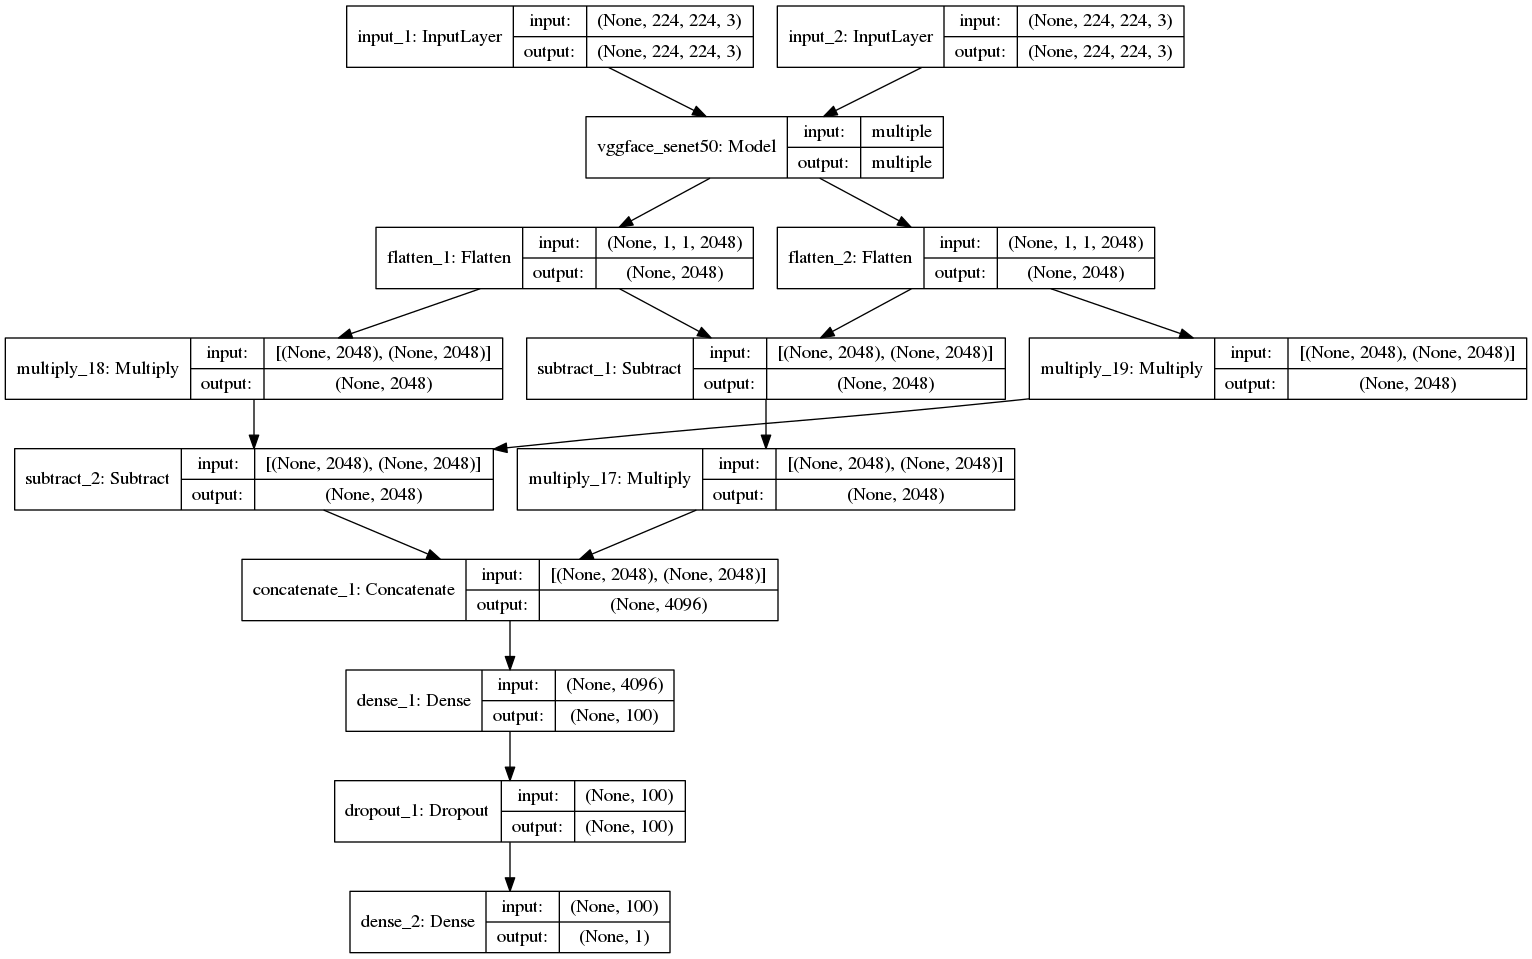

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [26]:

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

file_path = "vgg_face.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

#model.load_weights(file_path)
history = model.fit_generator(traingen, use_multiprocessing=True, workers=4,
                    validation_data=testgen, epochs=5, 
                    verbose=1, callbacks=callbacks_list, 
                    steps_per_epoch=200, validation_steps= len(X_test)//batch_size)

Epoch 1/5
200/200 [==============================] - 952s 5s/step - loss: 4.6220 - acc: 0.7227 - val_loss: 9.5327 - val_acc: 0.7882

Epoch 00001: val_acc improved from -inf to 0.78816, saving model to vgg_face.h5
Epoch 2/5
200/200 [==============================] - 914s 5s/step - loss: 1.8187 - acc: 0.8306 - val_loss: 4.8976 - val_acc: 0.8297

Epoch 00002: val_acc improved from 0.78816 to 0.82974, saving model to vgg_face.h5
Epoch 3/5
200/200 [==============================] - 914s 5s/step - loss: 1.2043 - acc: 0.8700 - val_loss: 3.9233 - val_acc: 0.8564

Epoch 00003: val_acc improved from 0.82974 to 0.85641, saving model to vgg_face.h5
Epoch 4/5
200/200 [==============================] - 913s 5s/step - loss: 0.8423 - acc: 0.8925 - val_loss: 2.8550 - val_acc: 0.8797

Epoch 00004: val_acc improved from 0.85641 to 0.87972, saving model to vgg_face.h5
Epoch 5/5
200/200 [==============================] - 912s 5s/step - loss: 0.6337 - acc: 0.9066 - val_loss: 2.1350 - val_acc: 0.8846

Epoch 

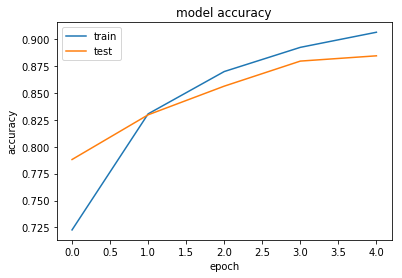

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


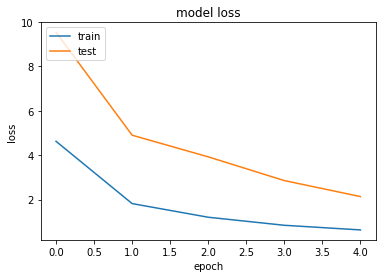

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
for x in model.layers:
    x.trainable = True
    

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]


model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))

history = model.fit_generator(traingen, use_multiprocessing=True, workers=4,
                    validation_data=testgen, epochs=20, 
                    verbose=1, callbacks=callbacks_list, 
                    steps_per_epoch=300, validation_steps=len(X_test)//batch_size)

Epoch 1/20
300/300 [==============================] - 932s 3s/step - loss: 0.4955 - acc: 0.9190 - val_loss: 2.2969 - val_acc: 0.9048

Epoch 00001: val_acc improved from -inf to 0.90475, saving model to vgg_face.h5
Epoch 2/20
300/300 [==============================] - 943s 3s/step - loss: 0.2881 - acc: 0.9318 - val_loss: 0.8834 - val_acc: 0.9134

Epoch 00002: val_acc improved from 0.90475 to 0.91341, saving model to vgg_face.h5
Epoch 3/20
300/300 [==============================] - 948s 3s/step - loss: 0.2569 - acc: 0.9375 - val_loss: 0.5506 - val_acc: 0.9227

Epoch 00003: val_acc improved from 0.91341 to 0.92271, saving model to vgg_face.h5
Epoch 4/20
300/300 [==============================] - 933s 3s/step - loss: 0.2026 - acc: 0.9470 - val_loss: 0.2077 - val_acc: 0.9296

Epoch 00004: val_acc improved from 0.92271 to 0.92961, saving model to vgg_face.h5
Epoch 5/20
300/300 [==============================] - 939s 3s/step - loss: 0.1812 - acc: 0.9522 - val_loss: 0.1816 - val_acc: 0.9351

E

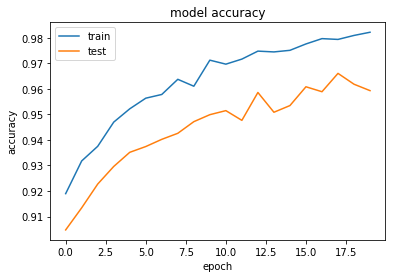

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


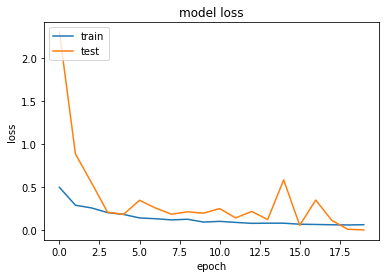

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
with zipfile.ZipFile("/kaggle/input/recognizing-faces-in-the-wild/test.zip","r") as z:
    z.extractall("/kaggle/test")

In [33]:
test_path = "/kaggle/test/"


def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

submission = pd.read_csv('/kaggle/input/recognizing-faces-in-the-wild/sample_submission.csv')

predictions = []

for batch in chunker(submission.img_pair.values):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x, preprocess=True) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x, preprocess=True) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

submission.to_csv("vgg_face.csv", index=False)